In [1]:
import MLMarker_app
import pandas as pd
import numpy as np
from MLMarker_app import MLMarker
import matplotlib.pyplot as plt
import random

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


Adapt everything to NSAF or binary depending on the model being used!

In [11]:
#if binary, adapt the test sample to binary values
binary = True
#remove some random features to see changes in the model performance
removal= False


test_sample= "/home/compomics/git/MLMarker/data/test_sample.csv"
#get the first row from the 'test sampl'e
test_sample = pd.read_csv(test_sample)
print(test_sample.shape)
test_sample = test_sample.iloc[1:2]

if binary:
    test_sample.iloc[:,5:] = np.where(test_sample.iloc[:,5:] > 0, 1, 0)
    
if removal: 
    test_features = test_sample.columns[5:]
    remove_features = random.sample(list(test_features), 100)
    test_sample = test_sample.drop(columns=remove_features)

test_sample
test = MLMarker(test_sample, binary = False)

(13, 11897)


Trying to unpickle estimator DecisionTreeClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
Trying to unpickle estimator RandomForestClassifier from version 1.5.1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations


In [10]:
test_sample.T.value_counts()

1       
0           9902
0.000279       8
0.000559       7
0.000093       6
0.000178       5
            ... 
0.000235       1
0.000044       1
0.000044       1
0.000232       1
0.000254       1
Name: count, Length: 1497, dtype: int64

In [5]:
x = MLMarker.predict_top_tissues(test)
x

[('Urinary bladder', 0.2534),
 ('Stomach', 0.1142),
 ('Esophagus', 0.0763),
 ('Ovary', 0.0595),
 ('Colon', 0.0571)]

In [6]:
shap_df = MLMarker.shap_values_df(test, n_preds=1).reset_index()
shap_df

,tissue,A0A075B6H7,A0A075B6I0,A0A075B6Q5,A0A0A0MS14,A0A0A0MS15,A0A0B4J1U7,A0A0B4J1V0,A0A0B4J1V6,A0A0B4J1X8,...,Q9Y6U3,Q9Y6V0,Q9Y6V7,Q9Y6W3,Q9Y6W5,Q9Y6X5,Q9Y6X8,Q9Y6X9,Q9Y6Y0,Q9Y6Y8
0,Urinary bladder,0.000007,0.000334,0.0,-0.000032,0.00001,8.360682e-07,0.000002,0.000003,0.0,...,-0.000131,0.000158,0.0,9.018768e-07,-0.000002,0.000002,0.000019,0.0,0.0,9.586401e-07


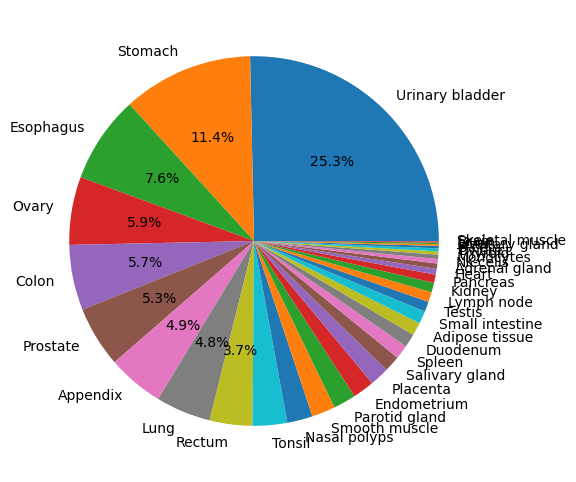

In [7]:
MLMarker.pie_chart_predictions(test)

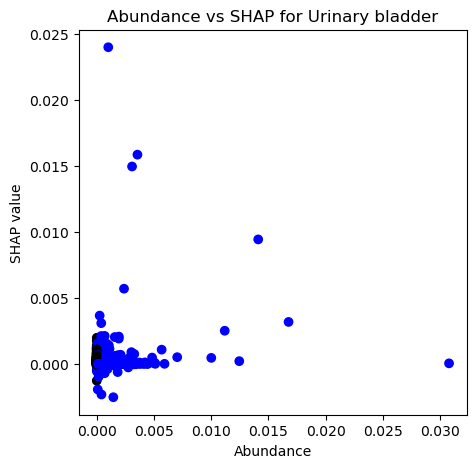

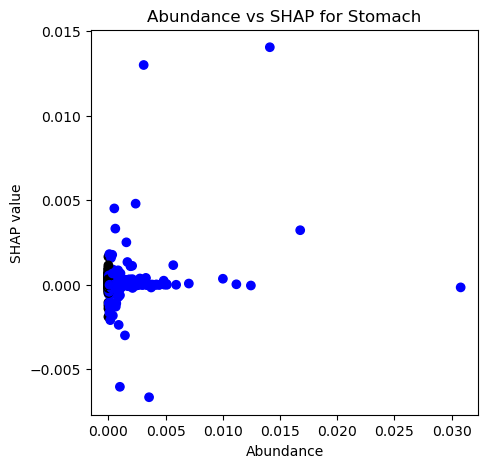

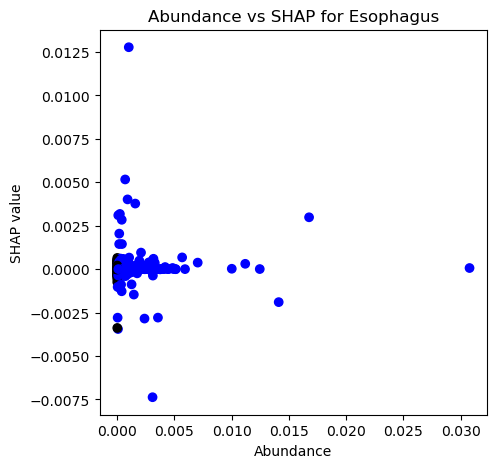

In [8]:
MLMarker.shap_abundance_distribution(test, n_preds=3)

The base value is 0.028571428571428373
Urinary bladder


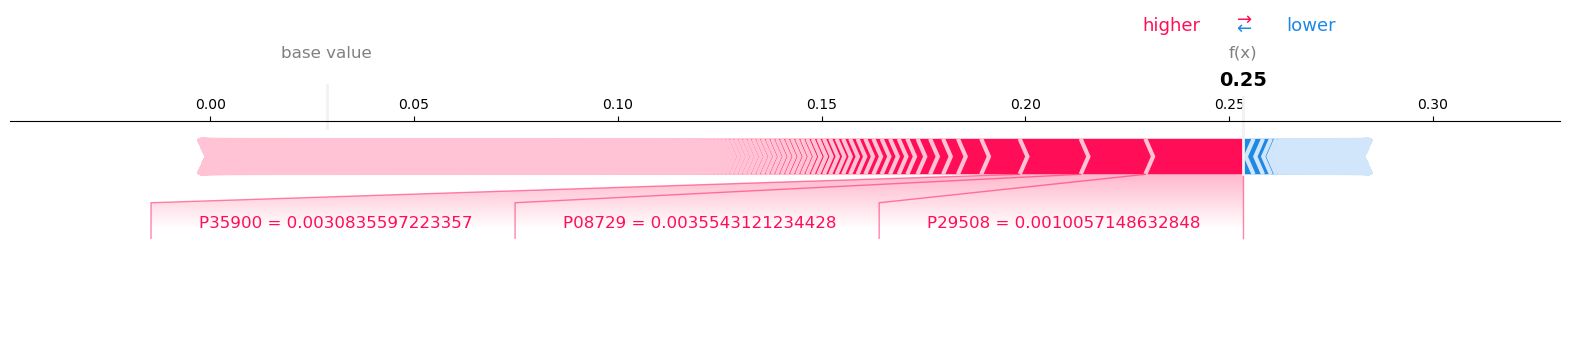

None

Stomach


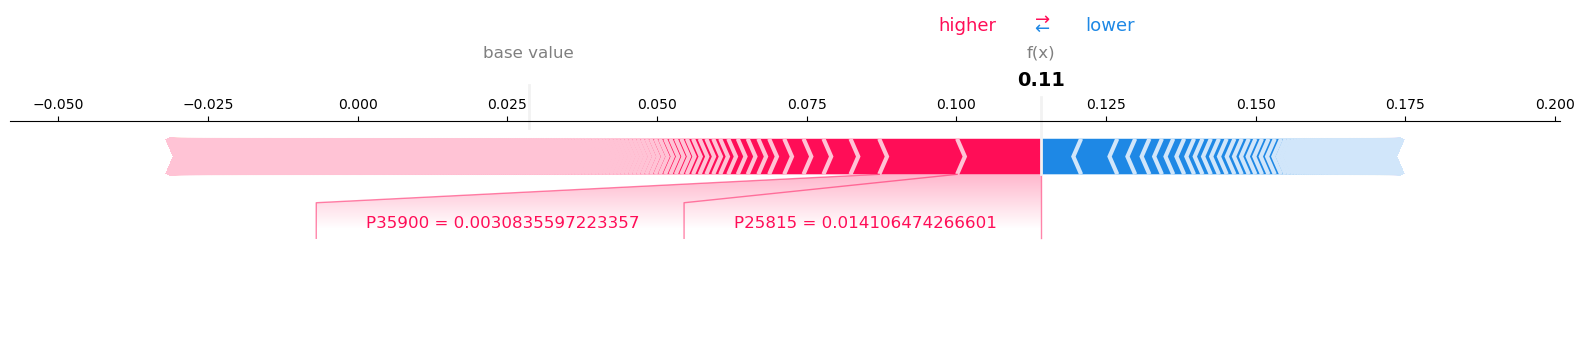

None

Esophagus


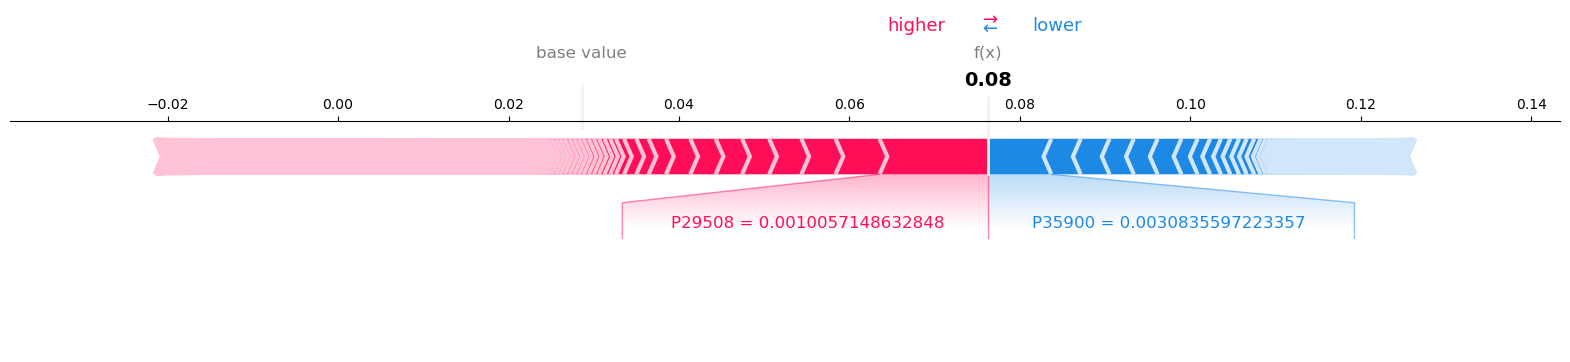

None

In [9]:
MLMarker.visualize_shap_force_plot(test, n_preds=3) 

**Determine a confidence score for a prediction based on:** <br>
    - #training instances for said tissue, we want this to be high <br>
    - delta: distance btw prediction and base-value, we want this to be high<br>
    - impact of missingness: how many absent features contribute versus how many present and what is the weight of them?
    - positive_SHAP_0: features that are absent and give a positive impact<br>
    - positive_SHAP_1: features that are present and give a positive impact<br>
    - negative_SHAP_0: features that are absent and give a negative impact<br>
    - negative_SHAP_1: features that are present and give a negative impact<br>

In [234]:
def confidence_scoring(n_preds=10):
    shap_df = MLMarker.shap_values_df(test, n_preds=n_preds).reset_index()
    abundance_df = MLMarker.read_sample(test,test_sample)
    instances = MLMarker.training_instances(test, n_preds)
    probabilities = MLMarker.predict_top_tissues(test, n_preds)
    confidence_tissues = []
    for i in range(n_preds):
        tissue = shap_df.iloc[i-1, 0]
        print('Started calculations for {}'.format(tissue))
        tissue_shap = shap_df.iloc[i:i+1, 1:]
        tissue_prob = next(item[1] for item in probabilities if item[0] == tissue)
        instances_tissue = instances[instances['tissue_name'] == tissue]['% training instances'].values[0]
        missingness_tissue = instances[instances['tissue_name'] == tissue]['average % of missingness'].values[0]


        combined_df = pd.concat([tissue_shap, abundance_df], axis=0)
        combined_df['index'] = ['shap_values', 'abundance']
        combined_df.set_index(['index'], inplace=True)
        #in combined_Df sum positive shap values where abundance >0
        avg_pro_1 = combined_df.loc['shap_values', (combined_df.loc['abundance'] > 0) & (combined_df.loc['shap_values'] > 0)].sum()
        number_pro_1 = combined_df.loc['shap_values', (combined_df.loc['abundance'] > 0) & (combined_df.loc['shap_values'] > 0)].shape[0]
        avg_pro_0 = combined_df.loc['shap_values', (combined_df.loc['abundance'] == 0) & (combined_df.loc['shap_values'] > 0)].sum()
        number_pro_0 = combined_df.loc['shap_values', (combined_df.loc['abundance'] == 0) & (combined_df.loc['shap_values'] > 0)].shape[0] #these are the ones that are not present in the sample but impact the prediction! we want this to not skew the score

        avg_anti_1 = combined_df.loc['shap_values', (combined_df.loc['abundance'] > 0) & (combined_df.loc['shap_values'] < 0)].sum()
        number_anti_1 = combined_df.loc['shap_values', (combined_df.loc['abundance'] > 0) & (combined_df.loc['shap_values'] < 0)].shape[0]
        avg_anti_0 = combined_df.loc['shap_values', (combined_df.loc['abundance'] == 0) & (combined_df.loc['shap_values'] < 0)].sum()
        number_anti_0 = combined_df.loc['shap_values', (combined_df.loc['abundance'] == 0) & (combined_df.loc['shap_values'] < 0)].shape[0]

        pro_ratio = ((avg_pro_1/number_pro_1)/(avg_pro_0/number_pro_0)) #a higher ratio is more impact of present features
        anti_ratio = ((avg_anti_1/number_anti_1)/(avg_anti_0/number_anti_0))
        ratio = (pro_ratio*anti_ratio)
        confidence_score = (pro_ratio*anti_ratio)/(missingness_tissue*instances_tissue)
        
        confidence_tissues.append((tissue, pro_ratio, anti_ratio, ratio, instances_tissue, missingness_tissue, tissue_prob, confidence_score))
    
    confidence_df = pd.DataFrame(confidence_tissues, columns=['Tissue', 'Pro_Ratio', 'Anti_Ratio', 'Pro/anti', 'Instances', 'Missingness', 'Tissue_Prob', 'Confidence_Score'])
    confidence_df['Confidence_Score'] = confidence_df['Confidence_Score'].astype(float)
    confidence_df.sort_values(by='Confidence_Score', ascending=False, inplace=True)
    confidence_df['norm_confidence_score'] = (confidence_df['Confidence_Score'] - confidence_df['Confidence_Score'].min()) / (confidence_df['Confidence_Score'].max() - confidence_df['Confidence_Score'].min())
    return confidence_df
confidence_scoring()


Started calculations for Tonsil
Started calculations for Urinary bladder
Started calculations for Stomach
Started calculations for Esophagus
Started calculations for Ovary
Started calculations for Colon
Started calculations for Prostate
Started calculations for Appendix
Started calculations for Lung
Started calculations for Rectum


,Tissue,Pro_Ratio,Anti_Ratio,Pro/anti,Instances,Missingness,Tissue_Prob,Confidence_Score,norm_confidence_score
7,Appendix,1.179078,2.806647,3.309255,1.21,75.367782,0.0494,0.036288,1.000000
0,Tonsil,2.212778,1.806832,3.998119,1.95,69.521422,0.0302,0.029492,0.791615
3,Esophagus,1.341681,2.523416,3.385618,1.86,72.995213,0.0763,0.024936,0.651922
1,Urinary bladder,2.167332,1.441612,3.124453,2.14,71.400680,0.2534,0.020448,0.514306
2,Stomach,2.947443,1.296779,3.822182,2.97,70.366281,0.1142,0.018289,0.448094
6,Prostate,2.464583,0.856231,2.110253,1.76,68.885343,0.0533,0.017406,0.421012
9,Rectum,4.031277,0.508785,2.051052,1.86,68.603829,0.0374,0.016074,0.380163
8,Lung,2.541937,0.520142,1.322168,4.55,67.679554,0.0481,0.004294,0.018940
5,Colon,1.978386,0.522285,1.033281,3.62,68.988796,0.0571,0.004137,0.014153
4,Ovary,2.321523,0.318230,0.738779,2.97,67.670105,0.0595,0.003676,0.000000


In [ ]:
Tissue	Pro_Ratio	Anti_Ratio	Pro/anti	Instances	Missingness	Tissue_Prob	Confidence_Score
1	Small intestine	15.868676	2.510521	39.838640	2.97	66.622265	0.2315	0.201339
2	Nasal polyps	4.346749	3.901694	16.959687	1.49	73.846022	0.1583	0.154136
3	Colon	8.047413	1.398427	11.253718	3.62	68.988796	0.1138	0.045062
4	Duodenum	2.655714	2.098212	5.572250	2.23	68.477889	0.1060	0.036490
0	Pancreas	6.903487	1.316631	9.089344	3.90	73.926753	0.0463	0.031526